# Exploratory Data Analysis Part One - Reviewer Centric Attributes

This notebook contains exploratory data analysis of the scraped review transaction data: 

* Section 1 - data cleaning and processing
* Section 2 - user ratings
* Section 3 - reviews by category, town and establishment
* Section 4 - distribution of ratings across categories 
* Section 5 - user previous posting information 
* Section 6 - review posting dates
* Section 7 - visitor locations
* Sections 8 to 11 - accomodation types, food cuisines and outlet types and attraction types
* Section 12 - feature engineering to prepare the data for use in further models. 

The data is saved for use in the Notebook - Building a First Predictive Model.

## Import Libraries and Files

In [1]:
import openpyxl
import pandas as pd
import statsmodels as sm
import scipy.stats
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import researchpy as rp
sns.set()
import numpy as np
import pickle
import calendar
from geopy.geocoders import Nominatim
import folium
import folium.plugins
import webbrowser
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

In [2]:
# Base data from scraped reviews brought in as 3 separate dataframes
hotels = pd.read_excel("All Hotels.xlsx", sheet_name = "Tabulated",engine = "openpyxl")
rest = pd.read_excel("All Restaurants.xlsx", sheet_name = "Tabulated",engine = "openpyxl")
attract = pd.read_excel("All Attractions.xlsx", sheet_name = "Tabulated",engine = "openpyxl")

# Section 1: Exploration of Dataset and Preprocessing

### Examine Dataset

In [3]:
# Shape of dataframes
print("Hotels:", hotels.shape)
print("Restaurants", rest.shape)
print("Attractions", attract.shape)

Hotels: (2473, 12)
Restaurants (6870, 12)
Attractions (1259, 12)


In [4]:
# Create a combined dataframe for later use
combined_df = pd.concat([hotels, rest, attract], axis = 0)
combined_df.shape

(10602, 12)

In [5]:
# Examine dataset
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10602 entries, 0 to 1258
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Name           10602 non-null  object        
 1   Category       10602 non-null  object        
 2   Town           10602 non-null  object        
 3   Type           10602 non-null  object        
 4   User           10602 non-null  object        
 5   Location       10223 non-null  object        
 6   Contributions  10602 non-null  int64         
 7   ReviewDate     10602 non-null  datetime64[ns]
 8   Title          10602 non-null  object        
 9   Review         10602 non-null  object        
 10  VisitDate      10602 non-null  object        
 11  Rating         10602 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 1.1+ MB


### Remove User Ids

In [6]:
# Assign unique ID to user and drop user column
combined_df = combined_df.assign(id=(combined_df['User']).astype('category').cat.codes)
combined_df.drop(columns = ["User"], axis = 1, inplace = True)

In [7]:
# Number of unique User ID's
combined_df.id.nunique()

7459

### Remove duplicates

In [8]:
# Check for duplicates where all items are matched - picked up during automated webscraping and combining process
combined_df[combined_df.duplicated()].head(2)

,Name,Category,Town,Type,Location,Contributions,ReviewDate,Title,Review,VisitDate,Rating,id
6037,LG Café,Food,Arundel,"British, Café","Worthing, United Kingdom",114,2019-07-07,Lovely new restaurant,"This is something a bit different, and we thor...",2019-07-01 00:00:00,5,5019
6038,LG Café,Food,Arundel,"British, Café","Worthing, United Kingdom",14,2019-07-07,Lovely dinner in new French Restaurant,We had dinner yesterday evening. I had the Cea...,2019-07-01 00:00:00,4,3314


In [9]:
# Remove duplicated rows
combined_df = combined_df.drop_duplicates()

In [10]:
# Check for rows where the review text, title, reviewer and review month are identical (missed above)
combined_df[combined_df.duplicated(["id","Review","Title","ReviewDate"],keep = False)].head(2)

,Name,Category,Town,Type,Location,Contributions,ReviewDate,Title,Review,VisitDate,Rating,id
6033,LG Café,Food,Arundel,"British, Café",,90,2019-06-29,Fabulous concept,Visited twice in last few weeks. First time ju...,2019-06-01 00:00:00,5,5600
6035,LG Café,Food,Arundel,"British, Café",,17,2019-06-15,Disappointing,Disappointing Saturday night - very limited me...,2019-06-01 00:00:00,2,1050


In [11]:
# Remove duplicated rows
combined_df.drop_duplicates(subset = ["id","Review","Title","ReviewDate"],inplace = True)

In [12]:
# Check for rows where the review text, title, reviewer and review month are identical
combined_df[combined_df.duplicated(["id","Review","Title","ReviewDate"],keep = False)].head()

,Name,Category,Town,Type,Location,Contributions,ReviewDate,Title,Review,VisitDate,Rating,id


In [13]:
# Get new dataframe shape
combined_df.shape

(10407, 12)

### Set datetime objects

In [14]:
# Convert VisitDate to datetime object - other variables already converted in EXCEL
combined_df['VisitDate'] =  pd.to_datetime(combined_df["VisitDate"])

In [15]:
# Pull out months of Reviews and Visit Dates from datetime objects and create two new columns
combined_df["ReviewMonth"] = pd.DatetimeIndex(combined_df['ReviewDate']).month
combined_df["VisitMonth"] = pd.DatetimeIndex(combined_df['VisitDate']).month

### Basic statistics

In [16]:
# Look at basic statistics of numerical data
combined_df.describe(include = "number")

,Contributions,Rating,id,ReviewMonth,VisitMonth
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,90.124916,4.194965,3688.585856,6.351494,6.440281
std,411.769907,1.226878,2141.481033,3.180764,3.177748
min,0.000000,1.000000,0.000000,1.000000,1.000000
25%,3.000000,4.000000,1811.500000,4.000000,4.000000
50%,16.000000,5.000000,3709.000000,6.000000,6.000000
75%,59.000000,5.000000,5524.500000,9.000000,9.000000
max,14575.000000,5.000000,7458.000000,12.000000,12.000000


In [17]:
# Look at basic statistics of categorical
combined_df.describe(include = "object")

,Name,Category,Town,Type,Location,Title,Review
count,10407,10407,10407,10407,10042,10407,10407
unique,386,3,3,66,1030,8714,10400
top,Butlins,Food,Bognor,"British, Pub/Bar",,Excellent,"Most rude staff I have ever met, don’t visit u..."
freq,546,6696,3828,2363,2378,45,2


In [18]:
# Save out file for Exploratory Data Analysis Part 2 and Text Attributes Machine Learning Models
combined_df.to_csv("CombinedDataFrame.csv")

In [19]:
# Drop Title, Review and User (Text variables to be considered separately) 
combined_df = combined_df.drop(["ReviewDate","VisitDate"], axis = 1)

# Section 2: Ratings

In [20]:
# Get spread of reviews by rating
combined_df["Rating"].value_counts()

5    6253
4    1976
3     877
1     745
2     556
Name: Rating, dtype: int64

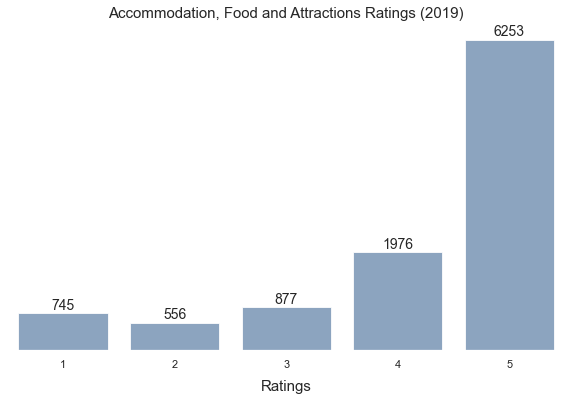

In [21]:
# Set variables
stars = combined_df.Rating.value_counts()
stars=stars.sort_index()
#colours = YlGnBu

# Plot chart
plt.figure(figsize=(10,6))
ax= sns.barplot(stars.index, stars.values, color = "xkcd:faded blue", alpha = 0.8)
ax.set_facecolor("white")
ax.set_title("Accommodation, Food and Attractions Ratings (2019)", fontsize = 15)
ax.set_xlabel('Ratings', fontsize = 15, labelpad = 10)
ax.set_yticklabels([])
rects = ax.patches
labels = stars.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom',fontsize = 14)
plt.show();

In [22]:
# Average rating
combined_df["Rating"].mean()

4.194964927452676

# Section 3: Number of Reviews By Category,Town and Establishment

In [23]:
# Create a copy of the dataframe
combined = combined_df.copy()

In [24]:
combined.head(2)

,Name,Category,Town,Type,Location,Contributions,Title,Review,Rating,id,ReviewMonth,VisitMonth
0,Butlins,Accommodation,Bognor,Hotel,"Hitchin, United Kingdom",25,"Nice break, shame about the accommodation...",We booked our 3 night stay from 27-30 December...,4,6804,12,12
1,Butlins,Accommodation,Bognor,Hotel,"London, United Kingdom",69,Horrendous noise Oyster Bay,In Oyster Bay. Oh dear.\n\nVery poor sound ins...,1,1536,12,12


In [25]:
# Groupby Towns and Category and get number of unique establishments
num_reviews = combined.groupby(["Town","Category"])["Rating"].count()
num_ests = combined_df.groupby(["Town","Category"])["Name"].nunique()

In [26]:
# Create dataframe of grouped data - number of reviews by town and category
num_reviews = num_reviews.reset_index()
num_reviews = num_reviews.pivot(index='Category', columns='Town', values='Rating')
num_reviews.columns = ["Arundel","Bognor","Littlehampton"]
num_reviews

,Arundel,Bognor,Littlehampton
Category,,,
Accommodation,817,1035,621
Attractions,694,322,222
Food,2214,2471,2011


In [27]:
# Create dataframe of grouped data - number of establishments by town and category
num_ests = num_ests.reset_index()
num_ests = num_ests.pivot(index='Category', columns='Town', values='Name')
num_ests.columns = ["Arundel","Bognor","Littlehampton"]
num_ests

,Arundel,Bognor,Littlehampton
Category,,,
Accommodation,23,27,20
Attractions,34,25,22
Food,46,104,96


In [28]:
# Graphing function
def graphing_function(df,name,name2,figsize,ylim,bb):
    pos =list(range(len(df.iloc[:,0])))
    width = 0.25 
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor("white")
    ax.bar(pos, df.iloc[:,0].values, width,label=df.index[0], color = "xkcd:faded blue") 
    ax.bar([p + width for p in pos], df.iloc[:,1].values,width,label= df.index[1], color = "xkcd:bluish grey") 
    ax.bar([p + width*2 for p in pos],df.iloc[:,2].values,width,label=df.index[2], color = "xkcd:slate grey") 
    ax.set_title(name, fontsize = 18)
    ax.set_ylim(ylim)
    ax.grid(axis = 'y', color = "grey", linestyle = ":", alpha = 0.8)
    ax.set_ylabel(name2, fontsize = 15,labelpad = 15)
    ax.set_xticks([p + 1 * width for p in pos])
    ax.set_xticklabels(df.index)
    ax.set_xlim(min(pos)-width, max(pos)+width*4)
    ax.legend(['Arundel', 'Bognor','Littlehampton'],loc='upper left', frameon = False, bbox_to_anchor = (bb))
    plt.show()

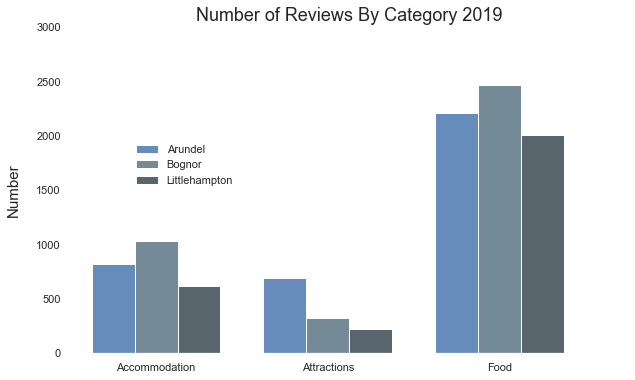

In [29]:
# Run function
graphing_function(num_reviews, "Number of Reviews By Category 2019","Number",(10,6),(0,3000),(0.1,0.67))

Most reviews are for food in all towns. Bognor has the most reviews for accommodation and food and Arundel has the most reviews for attractions.

In [30]:
# Number of reviews per establishment by Category
num_reviews_est = round(num_reviews/num_ests,2)
num_reviews_est

,Arundel,Bognor,Littlehampton
Category,,,
Accommodation,35.52,38.33,31.05
Attractions,20.41,12.88,10.09
Food,48.13,23.76,20.95


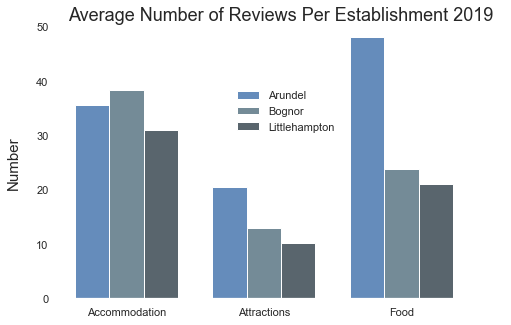

In [31]:
graphing_function(num_reviews_est, "Average Number of Reviews Per Establishment 2019","Number",(8,5),(0,50),(0.38,0.8))

The most reviews left for food and attractions per establishment are in Arundel and the most reviews per accommodation establishment are in Bognor.

## Most Reviewed and Highest Rated Accommodation

In [32]:
# Top Ten accommodation establishments in Arun
hotels_top = combined[combined["Category"] == "Accommodation"]["Name"].value_counts().head(10)
hotels_top

Butlins                      546
Avisford                     184
Norfolk Arms                 133
Premier Inn Bognor           121
Travelodge Fontwell          114
Church Farm                  113
Bailiffs Court               110
Travelodge Littlehampton     109
Premier Inn Littlehampton     89
Inglenook                     72
Name: Name, dtype: int64

In [33]:
# Plot the top accommodation establishments by number of reviews
def plot_est(category,title):
    fig, ax = plt.subplots()
    ax.barh(category.index,category, color = "xkcd:faded blue", alpha = 0.8)
    ax.set_title(title)
    ax.set_facecolor("white")
    ax.invert_yaxis()
    plt.show()

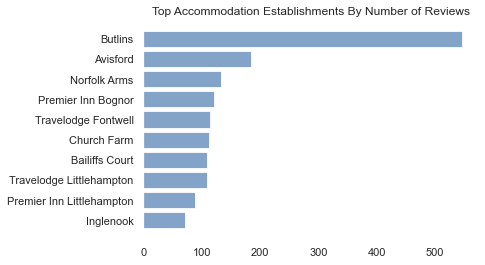

In [34]:
plot_est(hotels_top,"Top Accommodation Establishments By Number of Reviews")

In [35]:
hotel_average = combined[combined["Category"] == "Accommodation"].groupby(["Name","Rating"],as_index = False)["Review"].count().sort_values(by = "Review",ascending = False).head(10)
hotel_average

,Name,Rating,Review
36,Butlins,5,224
35,Butlins,4,150
34,Butlins,3,75
185,Travelodge Littlehampton,5,74
180,Travelodge Fontwell,5,71
28,Bailiffs Court,5,65
93,Norfolk Arms,5,64
32,Butlins,1,60
114,Premier Inn Bognor,5,59
70,Inglenook,5,58


In [36]:
hotel_average["Rating"].mean()

4.3

In [37]:
hotel_top_rated = combined[(combined["Category"] == "Accommodation") & (combined["Rating"] == 5)].groupby("Name",as_index = False)["Rating"].count()
hotel_top_rated.set_index("Name",inplace = True)

In [38]:
hotel_top_rated = hotel_top_rated.sort_values(by = "Rating",ascending = False).head(10)

In [39]:
def plot_rat(x,y,title):
    fig, ax = plt.subplots()
    ax.barh(x,y, color = "xkcd:faded blue", alpha = 0.8)
    ax.set_title(title)
    ax.set_xlabel("Number of Reviews", fontsize = 10,labelpad = 12)
    ax.set_facecolor("white")
    ax.invert_yaxis()
    plt.show()

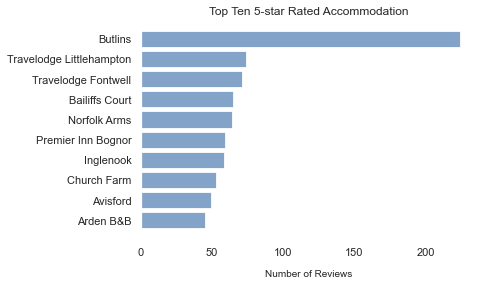

In [40]:
plot_rat(hotel_top_rated.index,hotel_top_rated.Rating,"Top Ten 5-star Rated Accommodation")

## Most Reviewed and Highest Rated Food Outlets

In [41]:
# Top ten food establishments in Arun
rests_top = combined[combined["Category"] == "Food"]["Name"].value_counts().head(10)
rests_top

Crossbush, Beefeater       189
Black Rabbit               177
Mustards                   174
The Mezze                  171
The Windmill, Harvester    143
Black Horse                141
The Roundstone             136
Fino                       135
Establo Lounge             125
Robin Hood                 125
Name: Name, dtype: int64

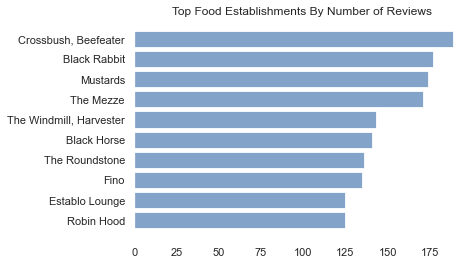

In [42]:
plot_est(rests_top,"Top Food Establishments By Number of Reviews")

In [43]:
food_average = combined[combined["Category"] == "Food"].groupby(["Name","Rating"],as_index = False)["Review"].count().sort_values(by = "Review",ascending = False).head(10)
food_average

,Name,Rating,Review
680,The Mezze,5,138
382,Mustards,5,133
416,Parsons Table,5,114
60,Black Horse,5,113
149,"Crossbush, Beefeater",5,112
197,Fino,5,93
453,Pub & Kitchen,5,88
652,The Gravy Boat,5,87
87,Butlins Fish and Chips,5,81
300,La Campagnia,5,81


In [44]:
food_average["Rating"].mean()

5.0

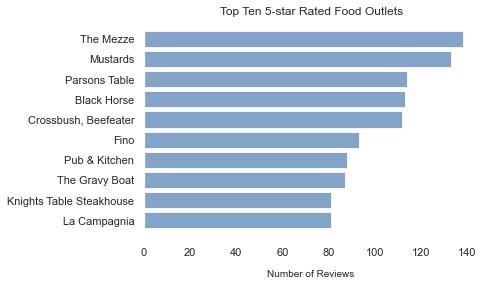

In [45]:
food_top_rated = combined[(combined["Category"] == "Food") & (combined["Rating"] == 5)].groupby("Name",as_index = False)["Rating"].count()
food_top_rated.set_index("Name",inplace = True)
food_top_rated = food_top_rated.sort_values(by = "Rating",ascending = False).head(10)
plot_rat(food_top_rated.index,food_top_rated.Rating,"Top Ten 5-star Rated Food Outlets")

## Most Reviewed and Highest Rated Attraction Venues

In [46]:
# Top ten attractions in Arun
attract_top = combined[combined["Category"] == "Attractions"]["Name"].value_counts().head(10)
attract_top

Arundel Castle         296
WWT Wetland             72
Hotham Park             68
Picturedrome            66
Hawking About           55
Arundel Cathedral       48
Littlehampton Beach     45
Denmans Gardens         43
Swanbourne Lake         30
Bognor Museum           28
Name: Name, dtype: int64

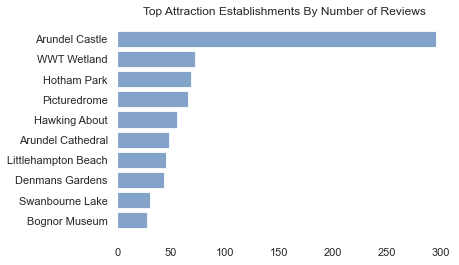

In [47]:
plot_est(attract_top,"Top Attraction Establishments By Number of Reviews")

In [48]:
attract_average = combined[combined["Category"] == "Attractions"].groupby(["Name","Rating"],as_index = False)["Review"].count().sort_values(by = "Review",ascending = False).head(10)
attract_average

,Name,Rating,Review
13,Arundel Castle,5,220
12,Arundel Castle,4,56
137,Picturedrome,5,54
86,Hawking About,5,54
90,Hotham Park,5,43
164,WWT Wetland,5,39
61,Denmans Gardens,5,29
21,Arundel Historic Tours,5,27
99,Littlehampton Beach,5,25
41,Bognor Museum,5,22


In [49]:
attract_average["Rating"].mean()

4.9

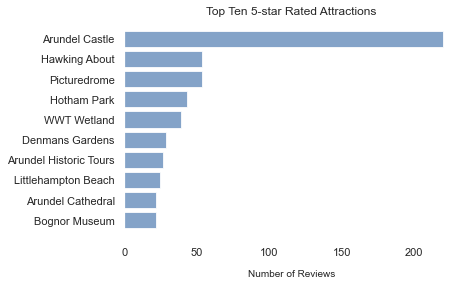

In [50]:
attract_top_rated = combined[(combined["Category"] == "Attractions") & (combined["Rating"] == 5)].groupby("Name",as_index = False)["Rating"].count()
attract_top_rated.set_index("Name",inplace = True)
attract_top_rated = attract_top_rated.sort_values(by = "Rating",ascending = False).head(10)
plot_rat(attract_top_rated.index,attract_top_rated.Rating,"Top Ten 5-star Rated Attractions")

# Section 4: Relationships Between Ratings Given, Category and Town

## Ratings and Categories For the District

In [51]:
# Average rating by category
combined.groupby("Category")["Rating"].mean()

Category
Accommodation    4.080873
Attractions      4.476575
Food             4.185036
Name: Rating, dtype: float64

In [52]:
# Find ratings by category for all towns
cat_ratings = combined.groupby("Category")["Rating"].value_counts()
cat_ratings = pd.DataFrame(cat_ratings.unstack().T)
cat_ratings

Category,Accommodation,Attractions,Food
Rating,,,
1,179,37,529
2,147,24,385
3,275,73,529
4,566,282,1128
5,1306,822,4125


In [53]:
# Graphing function
def graphing_function2(df,name,name2,name3,leg,figsize):
    pos =list(range(len(df.iloc[:,0])))
    width = 0.25 
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor("white")
    plt.bar(pos, df.iloc[:,0].values, width, alpha=0.5,label=df.index[0], color = "xkcd:faded blue") 
    plt.bar([p + width for p in pos], df.iloc[:,1].values,width,alpha=0.75, label= df.index[1], color = "xkcd:bluish grey") 
    plt.bar([p + width*2 for p in pos],df.iloc[:,2].values,width,alpha=0.75, label=df.index[2], color = "xkcd:slate grey") 
    ax.set_title(name, fontsize = 18)
    ax.set_ylabel(name2, fontsize = 13,labelpad = 10)
    ax.set_xlabel(name3, fontsize = 13, labelpad = 10)
    ax.set_xticks([p + 1 * width for p in pos])
    ax.set_xticklabels(df.index)
    plt.xlim(min(pos)-width, max(pos)+width*4)
    ax.legend(leg,frameon = False, bbox_to_anchor = (0.5,0.8))
    plt.show()

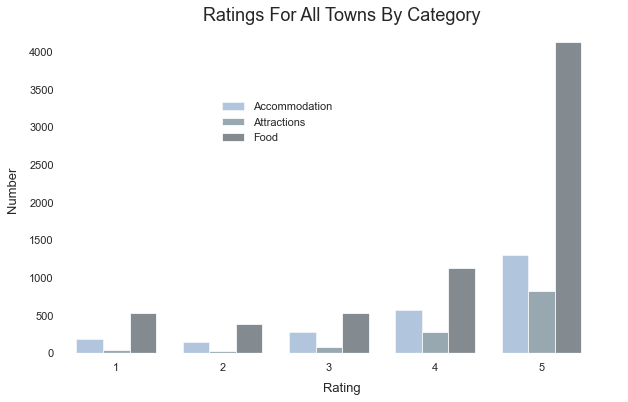

In [54]:
leg = ["Accommodation","Attractions","Food"]
graphing_function2(cat_ratings,"Ratings For All Towns By Category","Number","Rating",leg,(10,6))

In [55]:
cat_ratings_percent = cat_ratings.T.apply(lambda x: x*100/sum(x),axis = 1)
cat_ratings_percent

Rating,1,2,3,4,5
Category,,,,,
Accommodation,7.238172,5.944197,11.120097,22.887182,52.810352
Attractions,2.988691,1.938611,5.896607,22.778675,66.397415
Food,7.900239,5.749701,7.900239,16.845878,61.603943


In [56]:
def stacked(table,name):
    ax = table.plot(kind = "barh" ,stacked = True, 
                              color = ["xkcd:slate grey","xkcd:bluish grey",
                                       "xkcd:steel blue","xkcd:faded blue","lightsteelblue"],xlim = (0,120))
    ax.set_facecolor("white")
    ax.legend(frameon = False, bbox_to_anchor = (0.9,0.7))
    xticks = ax.xaxis.get_major_ticks() 
    xticks[6].label1.set_visible(False)
    ax.set_xlabel("%",labelpad = 10)
    ax.set_title(name, fontsize = 14)
    plt.show()

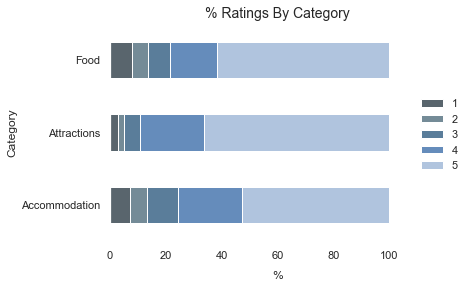

In [57]:
stacked(cat_ratings_percent,"% Ratings By Category")

Accommodation has the smallest proportion of 5-star rated establishments and attractions have the highest.

## Ratings By Towns - All Categories

In [58]:
# Average rating by town
combined.groupby("Town")["Rating"].mean()

Town
Arundel          4.286980
Bognor           4.201672
Littlehampton    4.065872
Name: Rating, dtype: float64

In [59]:
# Find ratings by town for all categories
town_ratings = combined.groupby("Town")["Rating"].value_counts()
town_ratings = pd.DataFrame(town_ratings.unstack().T)
town_ratings

Town,Arundel,Bognor,Littlehampton
Rating,,,
1,208,285,252
2,175,189,192
3,299,315,263
4,701,719,556
5,2342,2320,1591


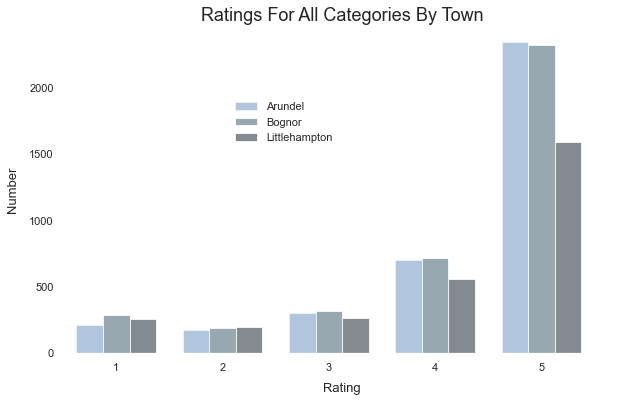

In [60]:
leg = ["Arundel","Bognor","Littlehampton"]
graphing_function2(town_ratings,"Ratings For All Categories By Town","Number","Rating",leg,(10,6))

In [61]:
town_ratings_percent = town_ratings.T.apply(lambda x: x*100/sum(x),axis = 1)

In [62]:
town_ratings_percent

Rating,1,2,3,4,5
Town,,,,,
Arundel,5.583893,4.697987,8.026846,18.818792,62.872483
Bognor,7.445141,4.937304,8.228840,18.782654,60.606061
Littlehampton,8.829713,6.727400,9.215137,19.481430,55.746321


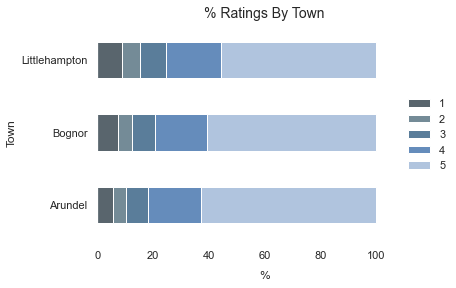

In [63]:
stacked(town_ratings_percent,"% Ratings By Town")

Littlehampton has the smallest proportion of 5-star rated establishments across all categories and Bognor and Arundel are roughly the same.

## Ratings By Town For Each Category

### Accommodation

In [64]:
# Hotel ratings by Town
hotel_rating = combined[combined["Category"] == "Accommodation"].groupby("Town")["Rating"].value_counts()
hotel_rating = pd.DataFrame(hotel_rating.unstack().T)

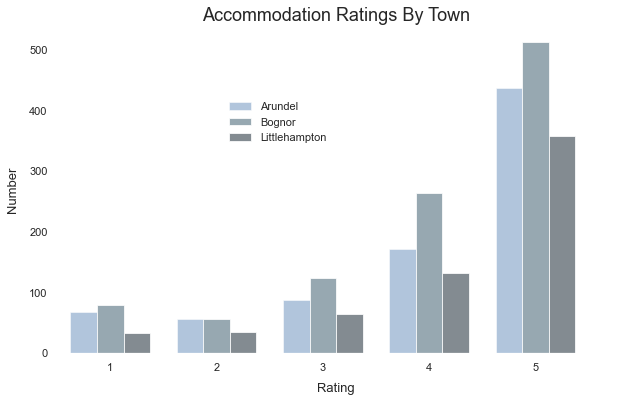

In [65]:
graphing_function2(hotel_rating,"Accommodation Ratings By Town","Number","Rating",leg,(10,6))

In [66]:
hotel_rating_percent = hotel_rating.T.apply(lambda x: x*100/sum(x),axis = 1)

In [67]:
hotel_rating_percent

Rating,1,2,3,4,5
Town,,,,,
Arundel,8.200734,6.854345,10.648715,20.930233,53.365973
Bognor,7.632850,5.410628,11.980676,25.507246,49.468599
Littlehampton,5.314010,5.636071,10.305958,21.095008,57.648953


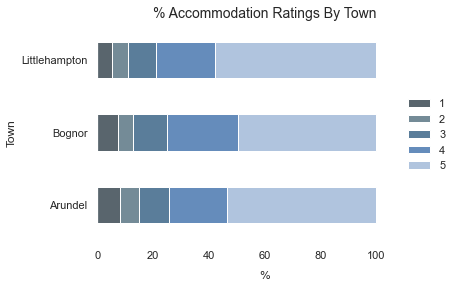

In [68]:
stacked(hotel_rating_percent,"% Accommodation Ratings By Town")

Within accommodation, Littlehampton has the highest proportion of 5-star rated establishments and Bognor the least.

### Food

In [69]:
# Food ratings by Town
food_rating = combined[combined["Category"] == "Food"].groupby("Town")["Rating"].value_counts()
food_rating = pd.DataFrame(food_rating.unstack().T)

In [70]:
food_rating

Town,Arundel,Bognor,Littlehampton
Rating,,,
1,128,196,205
2,106,127,152
3,174,170,185
4,377,395,356
5,1429,1583,1113


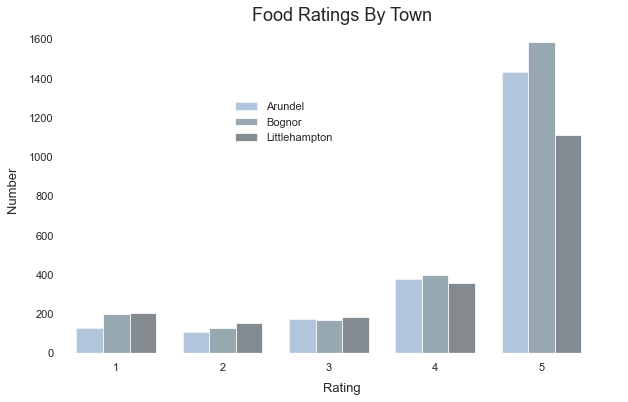

In [71]:
graphing_function2(food_rating,"Food Ratings By Town","Number","Rating",leg,(10,6))

In [72]:
food_rating_percent = food_rating.T.apply(lambda x: x*100/sum(x),axis = 1)

In [73]:
food_rating_percent

Rating,1,2,3,4,5
Town,,,,,
Arundel,5.781391,4.787715,7.859079,17.028004,64.543812
Bognor,7.932011,5.139620,6.879806,15.985431,64.063132
Littlehampton,10.193933,7.558429,9.199403,17.702636,55.345599


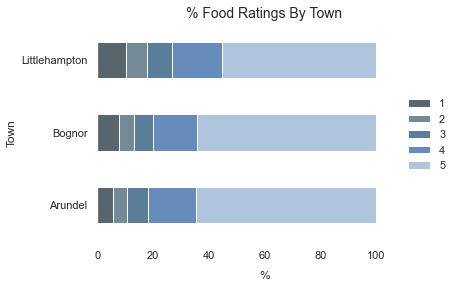

In [74]:
stacked(food_rating_percent,"% Food Ratings By Town")

Within the food category, Bognor and Arundel have a higher proportion of 5-star rated establishments than Littlehampton.

### Attractions

In [75]:
# Attraction ratings by Town
attract_rating = combined[combined["Category"] == "Attractions"].groupby("Town")["Rating"].value_counts()
attract_rating = pd.DataFrame(attract_rating.unstack().T)

In [76]:
attract_rating

Town,Arundel,Bognor,Littlehampton
Rating,,,
1,13,10,14
2,13,6,5
3,38,21,14
4,153,60,69
5,477,225,120


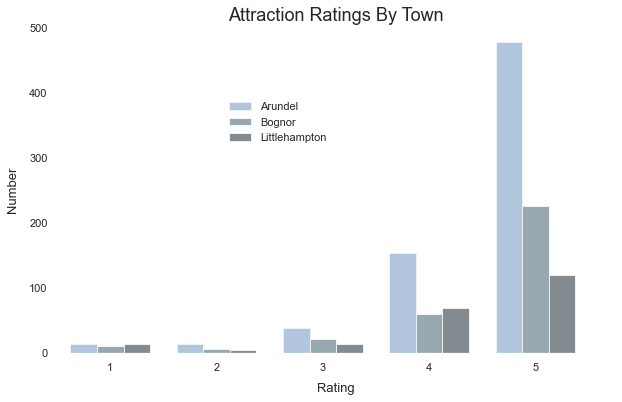

In [77]:
graphing_function2(attract_rating,"Attraction Ratings By Town","Number","Rating",leg,(10,6))

In [78]:
attract_rating_percent = attract_rating.T.apply(lambda x: x*100/sum(x),axis = 1)

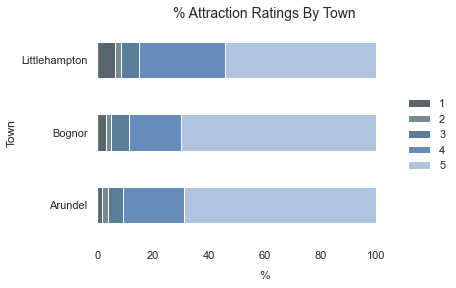

In [79]:
stacked(attract_rating_percent,"% Attraction Ratings By Town")

Within the attractions category, Arundel and Bognor have a higher proportion of 5-star venues than Littlehampton.

### Statistics for Category and Town against Ratings

Assumptions of Chi Squared are that there are no zero entries in the crosstab and no more than 20% less than five. However, With such a large sample size, the chi-squared test can overestimate differences so an addtional test for the strength of the relationship is run - Cramer's V.

In [80]:
# Function to create crosstab and calculate chi-square test to test relationship between variables and 
# Cramer's V strength of relationship
def statistical(test_name,var1,var2):
    crosstab, test_results, expected = rp.crosstab(var1,var2,
                                               test = 'chi-square', expected_freqs = True,
                                               prop = "cell")
    print(test_name)
    return test_results

In [81]:
# Relationship between Town and Rating
statistical("Town and Rating", combined["Town"],combined["Rating"])

Town and Rating


,Chi-square test,results
0,Pearson Chi-square ( 8.0) =,56.2227
1,p-value =,0.0000
2,Cramer's V =,0.0520


In [82]:
# Relationship between Category and Rating
statistical("Category and Rating", combined["Category"],combined["Rating"])

Category and Rating


,Chi-square test,results
0,Pearson Chi-square ( 8.0) =,176.6513
1,p-value =,0.0000
2,Cramer's V =,0.0921


There appears to be a relationship between the rating given and both category or review and town but the relationship is a weak one.

# Section 5: User Contributions

In [83]:
# Number of times Users added a review in 2019
user_counts = combined.id.value_counts()
user_counts.head()

1109    23
2279    18
4167    17
311     16
6892    15
Name: id, dtype: int64

In [84]:
# Mean number of times reviews left in 2019
combined.id.value_counts().mean()

1.3952272422576752

In [85]:
combined.drop(columns = ["id"], axis = 1, inplace = True)

In [86]:
# Basic Stats
combined.Contributions.describe()

count    10407.000000
mean        90.124916
std        411.769907
min          0.000000
25%          3.000000
50%         16.000000
75%         59.000000
max      14575.000000
Name: Contributions, dtype: float64

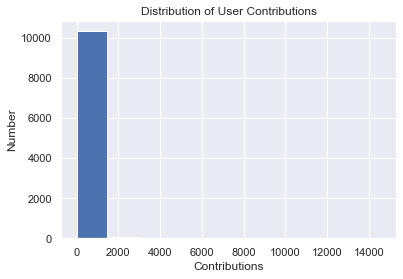

In [87]:
# Plot distribution
plt.hist(combined.Contributions, bins = 10)
plt.title("Distribution of User Contributions")
plt.xlabel("Contributions")
ax = plt.ylabel("Number")

In [88]:
# Check strength of positive skew
combined.Contributions.skew()

16.383149142190785

Appears that there might be some large outliers in the data. The data is heavily positively skewed.

In [89]:
# Check top user contributions and do manual check back to TripAdvisor to confirm correct
combined.sort_values(by = "Contributions", ascending = False).head(5)

,Name,Category,Town,Type,Location,Contributions,Title,Review,Rating,ReviewMonth,VisitMonth
1243,Littlehampton Harbour,Attractions,Littlehampton,Marina,"Derby, United Kingdom",14575,The river and boats,Pleasant walk along the harbour looking at the...,4,6,6
1257,Arundel Eccesntric Antiques,Attractions,Arundel,Speciality Shop,"London, United Kingdom",8226,A little off the beaten track,A sign to the complex of antique dealers in th...,4,8,8
1256,Squibbly Biskit,Attractions,Arundel,Speciality Shop,"London, United Kingdom",8226,Squashy kidsware,Tarrant Square announcer by a tall light on a ...,4,8,8
1182,Zimmer Gallery,Attractions,Arundel,Gallery,"London, United Kingdom",8225,Frost pere et fils,Zimmer Stewart is Arundel’s if not Sussex’s pr...,5,8,8
1202,Militaria,Attractions,Arundel,Speciality Shop,"London, United Kingdom",8225,Nuthouse,Militaria occupies a prominent position in a l...,4,8,8


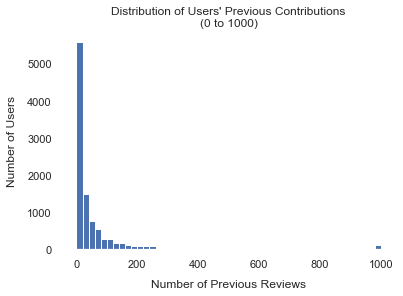

In [90]:
# Clip top values to see distribution at the lower end
figure, ax = plt.subplots()
ax.hist(np.clip(combined.Contributions, 0,1000), bins=50)
ax.set_facecolor("White")
ax.set_title("Distribution of Users' Previous Contributions\n(0 to 1000)", fontsize = 12)
ax.set_ylabel("Number of Users", labelpad = 10)
ax.set_xlabel("Number of Previous Reviews", labelpad = 10)
plt.show()

Clipping the outliers, shows that most users contribute under 50 reviews.

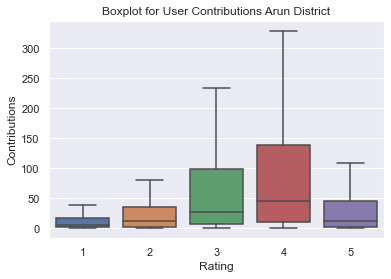

In [91]:
# Boxplot excluding outliers
sns.boxplot(x = combined["Rating"], y = combined["Contributions"],showfliers = False)
ax = plt.title("Boxplot for User Contributions Arun District")

Appears that users with low number of previous contributions tend to leave the highest and lowest rated reviews, perhaps due to particularly good or bad experiences causing them to leave a review. Ratings of  3 and 4 have users with a wider range of previous contributions, perhaps reflecting confidence and experience in rating their experience.

In [92]:
# Remove outlier values with z_scores greater than 3 from the dataset
combined["z_scores"] = stats.zscore(combined.Contributions)
combined["z_scores"] = np.abs(combined["z_scores"])
combined_no_outliers = combined.sort_values(by = "z_scores", ascending = False)
combined_no_outliers = combined_no_outliers[combined_no_outliers["z_scores"] < 3]
combined_no_outliers.drop(columns = ["z_scores"], axis = 1, inplace = True)
combined_no_outliers.shape

(10325, 11)

In [93]:
# Means and standard deviation for each rating
combined_no_outliers.groupby("Rating")["Contributions"].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
1,745.0,21.110067,51.704690,0.0,2.0,5.0,17.00,588.0
2,556.0,37.478417,84.932159,0.0,3.0,13.0,36.00,1064.0
3,870.0,82.389655,144.037334,0.0,7.0,26.0,94.75,1177.0
4,1937.0,119.376871,195.236396,0.0,11.0,43.0,129.00,1316.0
5,6217.0,49.267010,107.326723,0.0,3.0,12.0,44.00,1244.0


In [94]:
combined_no_outliers.describe()

,Contributions,Rating,ReviewMonth,VisitMonth
count,10325.00000,10325.000000,10325.000000,10325.000000
mean,62.54431,4.193705,6.360872,6.446102
std,131.57983,1.230371,3.178400,3.178428
min,0.00000,1.000000,1.000000,1.000000
25%,3.00000,4.000000,4.000000,4.000000
50%,16.00000,5.000000,6.000000,6.000000
75%,57.00000,5.000000,9.000000,9.000000
max,1316.00000,5.000000,12.000000,12.000000


In [95]:
combined_no_outliers["Contributions"].mean()

62.54430992736077

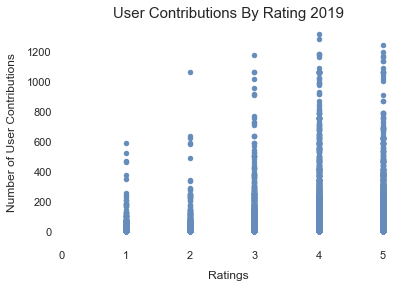

In [96]:
# Plot user contributions against rating value
ax = combined_no_outliers.plot(kind='scatter', x='Rating', y='Contributions',c = "xkcd:faded blue")
ax.set_facecolor("white")
ax.set_title("User Contributions By Rating 2019",fontsize = 15)
ax.set_xlabel("Ratings", labelpad = 10)
ax.set_xticks(np.arange(0,6,1))
ax.set_ylabel("Number of User Contributions", labelpad = 10)
plt.show()



#plt.xlabel("Ratings")
#plt.xticks(np.arange(0,6,1))
#ax = plt.ylabel("Number of User Contributions")

In [97]:
# Correlation between ratings and previous contributions
combined_no_outliers.Rating.corr(combined_no_outliers.Contributions)

0.012366113000995696

In [98]:
def stats_func(x,y):
    print("Shapiro Normality Test:",stats.shapiro(x))
    print("Levene Variance Test:",stats.levene(x[y == 1], x[y == 2], x[y == 3],x[y == 4],x[y == 5]))
    print("F-Test ANOVA:",stats.f_oneway(x[y == 1],x[y == 2], x[y == 3],x[y == 4],x[y == 5]))

In [99]:
stats_func(combined_no_outliers["Contributions"],combined_no_outliers["Rating"])

Shapiro Normality Test: ShapiroResult(statistic=0.4907259941101074, pvalue=0.0)
Levene Variance Test: LeveneResult(statistic=115.99150168867908, pvalue=6.286871239934974e-97)
F-Test ANOVA: F_onewayResult(statistic=141.9811470406667, pvalue=2.4104948440319846e-118)


Null hypothesis that two or more groups have the same population mean. Results suggest we can reject the null hypothesis and there is variance in the means between the contributions and ratings given.

# Section 6: Review and Visit Months

In [100]:
# Create new copy dataframe without outliers
combined = combined_no_outliers.copy()

In [101]:
# Shape of new dataframe
combined.shape

(10325, 11)

In [102]:
# Save out file for Exploratory Data Analysis Part 2 and Text Attributes Machine Learning Models
combined.to_csv("CombinedDataFrame.csv")

In [103]:
# How is the data distributed?
print("Visit Month Skew:",combined["VisitMonth"].skew())
print("Review Month Skew:", combined["ReviewMonth"].skew())

Visit Month Skew: 0.04093635071196164
Review Month Skew: 0.03578153379793066


Data appears normally distributed

In [104]:
# Convert integer months to string months
combined['review_month'] = combined['ReviewMonth'].apply(lambda x: calendar.month_abbr[x])
combined['visit_month'] = combined['VisitMonth'].apply(lambda x: calendar.month_abbr[x])

In [105]:
# Create variables for number of reviews by post and visit month and create dataframe
date_post = combined['ReviewMonth'].value_counts().sort_index()
date_visit = combined['VisitMonth'].value_counts().sort_index()
date_df = pd.concat([date_post, date_visit], axis=1)
date_df.index = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
date_df

,ReviewMonth,VisitMonth
Jan,711,638
Feb,740,705
Mar,791,815
Apr,1099,1094
May,1008,1044
Jun,983,933
Jul,923,952
Aug,1152,1177
Sep,889,873
Oct,827,811


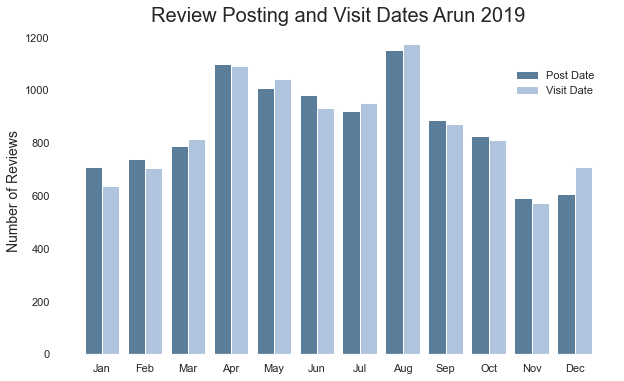

In [106]:
# Compare the distribution of visit dates and review posting dates over the year
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(date_df["ReviewMonth"]))

bar_width = 0.4

b1 = ax.bar(x, date_df["ReviewMonth"],width=bar_width, color = "xkcd:steel blue")
b2 = ax.bar(x + bar_width, date_df["VisitMonth"],width=bar_width, color = "lightsteelblue")
plt.title("Review Posting and Visit Dates Arun 2019", fontsize = 20)
ax.set_facecolor("white")
ax.set_ylabel("Number of Reviews", fontsize = 14)
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(date_df.index)
plt.legend(['Post Date', 'Visit Date'], loc='upper left', frameon = False, bbox_to_anchor = (0.8,0.9))
plt.show()

In [107]:
# Find mean rating by month
mean_of_ratings = combined.groupby("ReviewMonth")["Rating"].mean()
mean_of_ratings

ReviewMonth
1     4.296765
2     4.182432
3     4.241466
4     4.198362
5     4.252976
6     4.204476
7     4.119177
8     4.116319
9     4.053993
10    4.247884
11    4.257576
12    4.228618
Name: Rating, dtype: float64

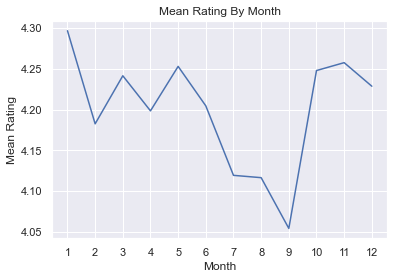

In [108]:
# Plot mean rating by month
plt.plot(mean_of_ratings)
plt.title("Mean Rating By Month")
plt.xlabel("Month")
plt.ylabel("Mean Rating")
ax = plt.xticks(mean_of_ratings.index)

There does appear to be a dip in the mean rating in September but the data is skewed.

In [109]:
# Contingency table ratings by post month 
contingency = pd.crosstab(combined.Rating,combined.ReviewMonth)
contingency.columns = date_df.index
contingency

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Rating,,,,,,,,,,,,
1,32,56,45,78,65,65,91,87,75,56,42,53
2,38,47,45,55,44,50,50,76,55,42,23,31
3,55,53,65,105,85,84,68,101,98,57,53,46
4,148,134,155,194,191,204,163,240,180,158,98,72
5,438,450,481,667,623,580,551,648,481,514,378,406


In [110]:
contingency_percent = contingency.T.apply(lambda x: x*100/sum(x),axis = 1)
contingency_percent

Rating,1,2,3,4,5
Jan,4.500703,5.344585,7.735584,20.815752,61.603376
Feb,7.567568,6.351351,7.162162,18.108108,60.810811
Mar,5.689001,5.689001,8.217446,19.595449,60.809102
Apr,7.097361,5.004550,9.554140,17.652411,60.691538
May,6.448413,4.365079,8.432540,18.948413,61.805556
Jun,6.612411,5.086470,8.545270,20.752798,59.003052
Jul,9.859155,5.417118,7.367281,17.659805,59.696641
Aug,7.552083,6.597222,8.767361,20.833333,56.250000
Sep,8.436445,6.186727,11.023622,20.247469,54.105737
Oct,6.771463,5.078597,6.892382,19.105200,62.152358


In [111]:
def stacked(table,name):
    ax = table.plot(kind = "barh" ,stacked = True, 
                              color = ["xkcd:slate grey","xkcd:bluish grey",
                                       "xkcd:steel blue","xkcd:faded blue","lightsteelblue"],
                    xlim = (0,120), figsize = (8,6))
    ax.set_facecolor("white")
    ax.legend(frameon = False, bbox_to_anchor = (0.9,0.7))
    xticks = ax.xaxis.get_major_ticks() 
    xticks[6].label1.set_visible(False)
    ax.set_xlabel("%",labelpad = 10)
    ax.set_title(name, fontsize = 14)
    plt.show()

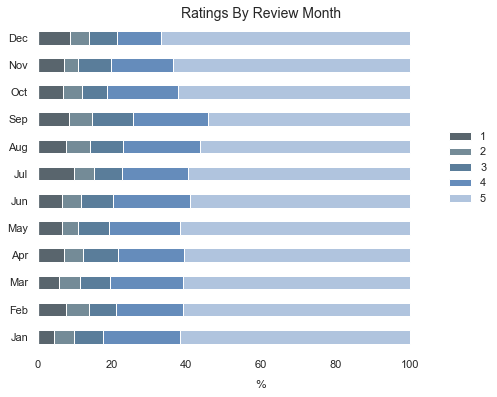

In [112]:
stacked(contingency_percent, "Ratings By Review Month")

In [113]:
statistical("Ratings by Review Month", combined["Contributions"], combined["Rating"])

Ratings by Review Month


,Chi-square test,results
0,Pearson Chi-square ( 1980.0) =,2826.7685
1,p-value =,0.0000
2,Cramer's V =,0.2616


The p-value is below 0.05 and the Cramer's V greater than 0.25, that there is a moderately strong relationship between month of posting review and the rating given. As the difference is in the third quarter of the year, the date will be split into four quarters.

In [114]:
# Drop unneeded columns from dataframe
combined.drop(["review_month","visit_month","VisitMonth"],axis = 1, inplace = True)

In [115]:
# Set ReviewMonth to either 1 -4 to represent quarters
combined.loc[combined["ReviewMonth"].between(1,3,inclusive = True),'Date'] = 1
combined.loc[combined["ReviewMonth"].between(4,6,inclusive = True),'Date'] = 2
combined.loc[combined["ReviewMonth"].between(7,9,inclusive = True),'Date'] = 3
combined.loc[combined["ReviewMonth"].between(10,12,inclusive = True),'Date'] = 4
combined.drop('ReviewMonth',axis = 1, inplace = True)

In [116]:
combined.head(2)

,Name,Category,Town,Type,Location,Contributions,Title,Review,Rating,Date
3120,Motte & Bailey,Food,Arundel,"European, Café","London, United Kingdom",1316,Nice For A Quiet Breakfast,I stopped by Motte and Bailey for a quick bite...,4,4.0
731,Norfolk Arms,Accommodation,Arundel,Hotel,"Brighton, United Kingdom",1278,Great value in the heart of arundel,Booked a room to stay the night in Arundel. Th...,4,4.0


# Section 7: Visitor Locations

In [117]:
# Split location string into separate columns to show town and country and strip whitespaces
combined[["Place","Country"]] = combined["Location"].str.split(",", expand = True)
combined["Country"] = combined["Country"].str.strip()

In [118]:
# Have a look at the top locations - not provided is shown as blank
combined["Location"].value_counts().head(10)

                                 2378
Bognor Regis, United Kingdom      718
London, United Kingdom            716
Littlehampton, United Kingdom     425
Worthing, United Kingdom          407
West Sussex, United Kingdom       288
Chichester, United Kingdom        264
Brighton, United Kingdom          228
Arundel, United Kingdom           156
Rustington, United Kingdom        142
Name: Location, dtype: int64

In [119]:
# Replace empty values with text
combined["Location"] = combined["Location"].replace([" "],"Not provided")
combined["Place"] = combined["Place"].replace([" "],"Not provided")

In [120]:
# Have a look at the top locations
combined["Location"].value_counts().head(20)

Not provided                      2378
Bognor Regis, United Kingdom       718
London, United Kingdom             716
Littlehampton, United Kingdom      425
Worthing, United Kingdom           407
West Sussex, United Kingdom        288
Chichester, United Kingdom         264
Brighton, United Kingdom           228
Arundel, United Kingdom            156
Rustington, United Kingdom         142
Portsmouth, United Kingdom         104
Southampton, United Kingdom         91
Horsham, United Kingdom             85
United Kingdom, United Kingdom      69
Felpham, United Kingdom             65
Angmering, United Kingdom           64
Crawley, United Kingdom             54
Surrey, United Kingdom              50
East Preston, United Kingdom        47
Guildford, United Kingdom           41
Name: Location, dtype: int64

In [121]:
combined.shape

(10325, 12)

In [122]:
# Get top 10 locations, drop UK as not specific and then list
top_locations_all = combined["Place"].value_counts().head(20)
top_locations_all.drop(labels=['United Kingdom'],inplace = True)
top_locations_all = top_locations_all.head(11)[1:]
#top_locations_all.drop(labels=['Not provided'],inplace = True)
top_locations_all

London           718
Bognor Regis     718
Littlehampton    425
Worthing         407
West Sussex      288
Chichester       264
Brighton         230
Arundel          156
Rustington       142
Portsmouth       104
Name: Place, dtype: int64

In [123]:
top_locations_all.shape

(10,)

In [124]:
# Top Locations for Visitors in all Categories 2019 plotting function

def plots(data, title):
    fig, ax = plt.subplots()
    ax.set_facecolor("white")
    ax.barh(data.index,data, color = "xkcd:faded blue", alpha = 0.8)
    ax.set_title(title,fontsize = 14)
    ax.set_xlabel("Number",labelpad = 10)
    ax.invert_yaxis()
    plt.show()

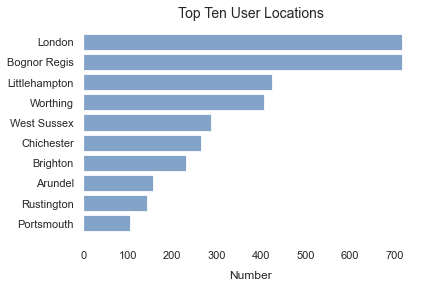

In [125]:
# Plot Top Ten Locations for All Reviews
plots(top_locations_all, "Top Ten User Locations")

In [126]:
# Top Ten Overseas Visitor Locations for All Reviews
top_locations_overseas = combined[combined["Country"] != "United Kingdom"]
top_locations_overseas = top_locations_overseas["Country"].value_counts().head(10)
top_locations_overseas

USA                85
Australia          71
Spain              35
Canada             27
France             26
Ireland            16
The Netherlands    11
Greece             10
Belgium            10
South Africa        9
Name: Country, dtype: int64

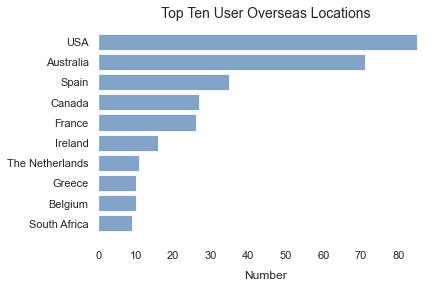

In [127]:
plots(top_locations_overseas, "Top Ten User Overseas Locations")

## Top User Locations for Accomodation Reviews

In [128]:
# Get top user locations for those leaving accommodation reviews
top_locations_hotels = combined[combined["Category"] == "Accommodation"]["Place"].value_counts().head(13)
#top_locations_hotels.drop(labels=[" "],inplace = True)
top_locations_hotels.drop(labels=["United Kingdom"],inplace = True)
top_locations_hotels = top_locations_hotels.head(12)[1:]

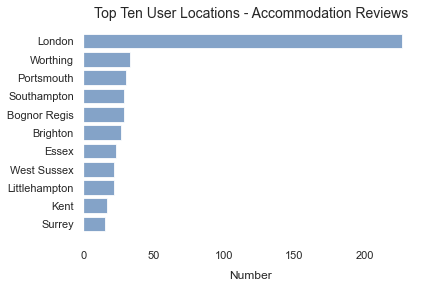

In [129]:
# Top Locations for Accommodation Reviews
plots(top_locations_hotels, "Top Ten User Locations - Accommodation Reviews")

## Top User Locations for Food Outlet Reviews

In [130]:
# Get top user locations for those leaving food reviews
top_locations_rests = combined[combined["Category"] == "Food"]["Place"].value_counts().head(11)
#top_locations_rests.drop(labels=[' '],inplace = True)
top_locations_rests[1:]

Bognor Regis     600
London           417
Littlehampton    345
Worthing         332
West Sussex      238
Chichester       223
Brighton         177
Rustington       129
Arundel          125
Horsham           63
Name: Place, dtype: int64

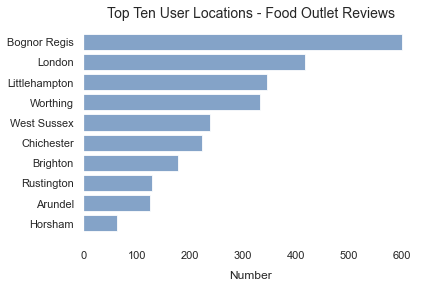

In [131]:
# Top locations for food outlet reviewers
plots(top_locations_rests[1:], "Top Ten User Locations - Food Outlet Reviews")

## Top User Locations for Attraction Reviews

In [132]:
# Top ten locations
top_locations_attracts = combined[combined["Category"] == "Attractions"]["Place"].value_counts().head(11)
#top_locations_attracts.drop(labels=[' '],inplace = True)
top_locations_attracts[1:]

Bognor Regis     89
London           74
Littlehampton    58
Worthing         42
West Sussex      28
Chichester       27
Brighton         26
Arundel          18
Portsmouth       17
Horsham          14
Name: Place, dtype: int64

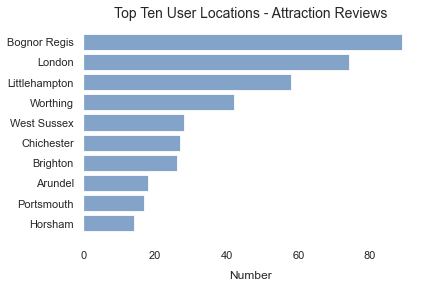

In [133]:
# Top ten locations for users leaving attraction reviews
plots(top_locations_attracts[1:], "Top Ten User Locations - Attraction Reviews")

In [134]:
# Get unique locations and create new dataframe. Check shape
locs = combined["Location"].unique()
locs = pd.DataFrame(locs, columns = ["Location"])
locs.shape

(1026, 1)

In [135]:
# Check first few entries
locs.head()

,Location
0,"London, United Kingdom"
1,"Brighton, United Kingdom"
2,"North Palm Beach, USA"
3,"Hamilton, New Zealand"
4,"Cardiff, United Kingdom"


In [136]:
# Import libraries
#geolocator = Nominatim(user_agent="arundistrict",timeout = 3)
#from geopy.extra.rate_limiter import RateLimiter
#geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Retrieve latitude and longitude, uncomment to run this codeblock (warning time intensive so read in csv below for ease)
#locs["Coordinates"] = locs["Location"].apply(geolocator.geocode,timeout = 10)
#locs["Latitude"]= locs["Coordinates"].apply(lambda x: x.latitude if x != None else None)
#locs["Longitude"] = locs["Coordinates"].apply(lambda x: x.longitude if x != None else None)
#locs.to_csv("locs.csv")

In [137]:
# Read back amended csv
locs = pd.read_csv("LocationDataArun.csv",index_col = 0)
#locs.to_csv("LocationDataArun.csv")

In [138]:
# Merge location data to original full dataframe
combined_locs = pd.merge(combined,locs, how = 'left', left_on = "Location", right_on = "Location")

In [139]:
# Isolate entries that are not null
combined_locs_all = combined_locs[~combined_locs["Latitude"].isnull()]

In [140]:
# Create function to draw maps

from folium.plugins import MarkerCluster

def map_locs(df,x,y):
    locations = df[["Latitude","Longitude"]].values.tolist()
    labels = df["Location"].values.tolist()
    centre_point = [x,y]
    
    #tooltip = "Click for Place"
        
    map = folium.Map(location=centre_point, zoom_start=2, tiles = "Stamen Terrain")
    marker_cluster = MarkerCluster().add_to(map)
    
    for point in range(len(locations)):
        popup = folium.Popup(labels[point], parse_html=True)        
        folium.Marker(locations[point], popup=popup).add_to(marker_cluster)
        
   
    map.save('ArunVisitors.html')
    webbrowser.open('ArunVisitors.html')
    
      

In [141]:
# Run function with the all location dataframe - will render in browser
map_locs(combined_locs_all,50.8080384,-0.7366638)

In [142]:
# Read in dataset of postcodes in the Arun area
arun_geocodes = pd.read_csv("Arun postcodes.csv")
arun_geocodes.columns

Index(['Postcode', 'In Use?', 'Latitude', 'Longitude', 'Easting', 'Northing',
       'Grid Ref', 'Ward', 'Parish', 'Introduced', 'Terminated', 'Altitude',
       'Country', 'Last Updated', 'Quality', 'LSOA Code', 'LSOA Name'],
      dtype='object')

In [143]:
# Find maximum and minimum latitudes and longitudes of postcodes
arun_geocodes.describe()

,Latitude,Longitude,Easting,Northing,Altitude
count,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,50.808663,-0.597055,498943.956522,101953.594151,8.608386
std,0.022773,0.087706,6151.852594,2601.726019,10.023617
min,50.763550,-0.754618,487914.000000,96746.000000,1.000000
25%,50.789268,-0.672426,493664.000000,99695.500000,5.000000
50%,50.807318,-0.616475,497561.000000,101924.000000,6.000000
75%,50.820402,-0.512950,504864.000000,103376.000000,8.000000
max,50.898163,-0.388306,513488.000000,111854.000000,132.000000


In [144]:
# Filter on geocodes and parish names to find Arun District
arun_district_locs = combined_locs_all[combined_locs_all["Latitude"].between(50.763550,50.898163,inclusive = True) & combined_locs_all["Longitude"].between(-0.754618,-0.388306, inclusive = True) &  combined_locs_all["Place"].isin(arun_geocodes["Parish"].values)] 
arun_district_locs.shape

(1707, 15)

In [145]:
# Arun District Reviews
arun_district_locs.Location.value_counts()

Bognor Regis, United Kingdom        718
Littlehampton, United Kingdom       425
Arundel, United Kingdom             156
Rustington, United Kingdom          142
Felpham, United Kingdom              65
Angmering, United Kingdom            64
East Preston, United Kingdom         47
Yapton, United Kingdom               23
Pagham, United Kingdom               20
Findon, United Kingdom               11
Aldwick, United Kingdom              11
Ferring, United Kingdom              10
Ford, United Kingdom                  5
Walberton, United Kingdom             3
Patching, United Kingdom              3
Climping, United Kingdom              3
Middleton-on-Sea, United Kingdom      1
Name: Location, dtype: int64

In [146]:
# Define local reviews
local = arun_district_locs["Location"].values

In [147]:
# Apply codes to locations based on being local, other UK and Overseas and apply to all locations dataframe
combined.loc[combined["Location"] == 'Not provided','LocCode']= 0
combined.loc[(combined["Location"].isin(local)), 'LocCode'] = 1
combined.loc[(~combined["Location"].isin(local)) & (combined["LocCode"] != 0) & (combined["Country"] == "United Kingdom"),'LocCode'] = 2
combined.loc[(~combined["Location"].isin(local)) & (combined["LocCode"] != 0) & (combined["Country"] != "United Kingdom"), 'LocCode'] = 3

In [148]:
x = combined.groupby("LocCode")["Rating"].mean()
x

LocCode
0.0    4.145500
1.0    4.208553
2.0    4.210161
3.0    4.192708
Name: Rating, dtype: float64

In [149]:
combined.LocCode.value_counts()

2.0    5472
0.0    2378
1.0    1707
3.0     768
Name: LocCode, dtype: int64

In [150]:
# Drop Country and Place columns no longer needed
combined.drop(columns = ["Place","Country","Location"], axis = 1, inplace = True)

In [151]:
combined.head(1)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode
3120,Motte & Bailey,Food,Arundel,"European, Café",1316,Nice For A Quiet Breakfast,I stopped by Motte and Bailey for a quick bite...,4,4.0,2.0


In [152]:
# Contingency table between location code and rating
loc_df = pd.crosstab(combined.Rating, combined.LocCode)
loc_df.columns = ["Not_provided","Local","OtherUK","ROW"]
loc_df.drop(columns = ["Not_provided"], axis = 1, inplace = True)

In [153]:
loc_df

,Local,OtherUK,ROW
Rating,,,
1,126,299,72
2,86,289,37
3,141,511,51
4,307,1237,119
5,1047,3136,489


In [154]:
loc_df_percent = loc_df.T.apply(lambda x: x*100/sum(x),axis = 1)
loc_df_percent

Rating,1,2,3,4,5
Local,7.381371,5.038079,8.260105,17.984769,61.335677
OtherUK,5.464181,5.281433,9.338450,22.605994,57.309942
ROW,9.375000,4.817708,6.640625,15.494792,63.671875


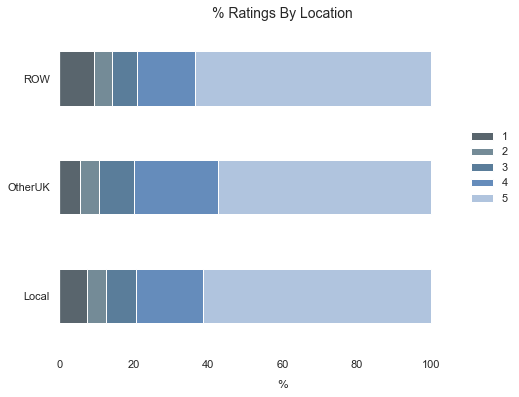

In [155]:
stacked(loc_df_percent,"% Ratings By Location")

In [156]:
# Filter out the rows where location is not given
combined = combined[combined["LocCode"]!= 0]

In [157]:
combined.head()

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode
3120,Motte & Bailey,Food,Arundel,"European, Café",1316,Nice For A Quiet Breakfast,I stopped by Motte and Bailey for a quick bite...,4,4.0,2.0
731,Norfolk Arms,Accommodation,Arundel,Hotel,1278,Great value in the heart of arundel,Booked a room to stay the night in Arundel. Th...,4,4.0,2.0
131,Arundel Castle,Attractions,Arundel,Historic,1244,Big surprise,From the outside the castle is very impressive...,5,2.0,3.0
1209,Digby Fine English,Attractions,Arundel,Wine Tours,1196,Very good wines,"Nice , helpful young man behind the counter.\n...",5,2.0,3.0
6464,Middleton Café,Food,Bognor,"British, Café",1179,1960s cafe,"This is a basic, clean and quaint cafe serving...",4,1.0,2.0


In [158]:
# Statistical test
statistical("Ratings By Location", combined["LocCode"], combined["Rating"])

Ratings By Location


,Chi-square test,results
0,Pearson Chi-square ( 8.0) =,59.9400
1,p-value =,0.0000
2,Cramer's V =,0.0614


There appears to be a weak relationship between user location and ratings given

# Section 8: Analysis of Accommodation Types

In [159]:
# Filter for accommodation
hotels = combined[combined["Category"] == "Accommodation"]
hotels.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode
731,Norfolk Arms,Accommodation,Arundel,Hotel,1278,Great value in the heart of arundel,Booked a room to stay the night in Arundel. Th...,4,4.0,2.0
2246,Town House,Accommodation,Arundel,B&B/Inn,1163,"Excellent food,service and ambience!",We’ve eaten here with a group of friends who g...,5,4.0,2.0


In [160]:
# Groupby town and type of accommodation
accoms = hotels.groupby("Town")["Type"].value_counts()
accoms = accoms.unstack().T
accoms.fillna(0)
accoms

Town,Arundel,Bognor,Littlehampton
Type,,,
B&B/Inn,117.0,99.0,47.0
Campsite,31.0,21.0,95.0
Hotel,465.0,618.0,267.0
Speciality,5.0,NaN,37.0


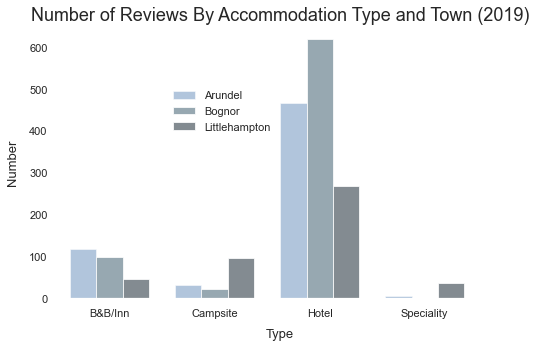

In [161]:
graphing_function2(accoms,"Number of Reviews By Accommodation Type and Town (2019)","Number","Type",leg,(8,5))

In [162]:
# Contingency table ratings by Accommodation Type
contingency = pd.crosstab(hotels.Rating,hotels.Type)
contingency

Type,B&B/Inn,Campsite,Hotel,Speciality
Rating,,,,
1,6,7,95,1
2,7,5,87,0
3,8,17,181,0
4,52,38,379,7
5,190,80,608,34


In [163]:
contingency_percent = contingency.T.apply(lambda x: x*100/sum(x),axis = 1)
contingency_percent

Rating,1,2,3,4,5
Type,,,,,
B&B/Inn,2.281369,2.661597,3.041825,19.771863,72.243346
Campsite,4.761905,3.401361,11.564626,25.850340,54.421769
Hotel,7.037037,6.444444,13.407407,28.074074,45.037037
Speciality,2.380952,0.000000,0.000000,16.666667,80.952381


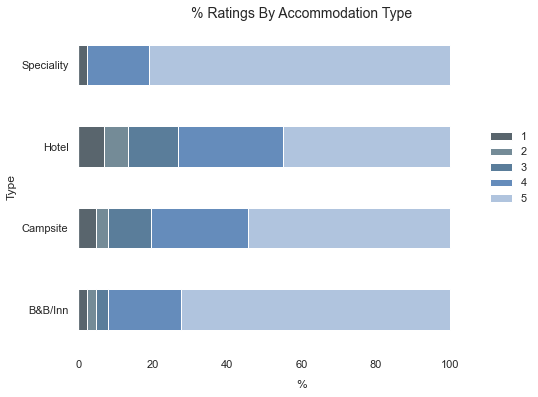

In [164]:
stacked(contingency_percent, "% Ratings By Accommodation Type",)

In [165]:
statistical("Rating By Accommodation Type", hotels.Type, hotels.Rating)

Rating By Accommodation Type


,Chi-square test,results
0,Pearson Chi-square ( 12.0) =,92.8303
1,p-value =,0.0000
2,Cramer's V =,0.1310


There appears to be a weak relationship between the rating given and the type of accommodation being reviewed

# Section 9: Analysis of Food Cuisines

In [166]:
# Filter for food reviews
food = combined[combined["Category"] == "Food"]

In [167]:
food.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode
3120,Motte & Bailey,Food,Arundel,"European, Café",1316,Nice For A Quiet Breakfast,I stopped by Motte and Bailey for a quick bite...,4,4.0,2.0
6464,Middleton Café,Food,Bognor,"British, Café",1179,1960s cafe,"This is a basic, clean and quaint cafe serving...",4,1.0,2.0


In [168]:
food.columns

Index(['Name', 'Category', 'Town', 'Type', 'Contributions', 'Title', 'Review',
       'Rating', 'Date', 'LocCode'],
      dtype='object')

In [169]:
food.shape

(5163, 10)

In [170]:
# Split cuisine column into two columns - Cuisine and Outlet
food[["Cuisine","Outlet"]] = food["Type"].str.split(",",expand=True,)

In [171]:
# Drop the Type column
food.drop(columns = ["Type"], axis = 1, inplace = True)

In [172]:
food.head(2)

,Name,Category,Town,Contributions,Title,Review,Rating,Date,LocCode,Cuisine,Outlet
3120,Motte & Bailey,Food,Arundel,1316,Nice For A Quiet Breakfast,I stopped by Motte and Bailey for a quick bite...,4,4.0,2.0,European,Café
6464,Middleton Café,Food,Bognor,1179,1960s cafe,"This is a basic, clean and quaint cafe serving...",4,1.0,2.0,British,Café


In [173]:
# Value counts by food cuisines
food["Cuisine"].value_counts()

British          2769
European          596
Italian/Pizza     449
Seafood           362
Indian            361
Mediterranean     183
American          152
Chinese           139
Thai               77
Vegetarian         51
Turkish            22
International       2
Name: Cuisine, dtype: int64

In [174]:
# Combine cuisines into smaller number of categories
food['Cuisine'] = food['Cuisine'].replace(['European','Mediterranean',"Turkish","Vegetarian"],'Other')
food['Cuisine'] = food['Cuisine'].replace(["Chinese","Thai"],'Chinese/Thai')
food.Cuisine.value_counts()

British          2769
Other             852
Italian/Pizza     449
Seafood           362
Indian            361
Chinese/Thai      216
American          152
International       2
Name: Cuisine, dtype: int64

In [175]:
cuisines = food.groupby("Town")["Cuisine"].value_counts()
cuisines = cuisines.unstack().T
cuisines.fillna(0)

Town,Arundel,Bognor,Littlehampton
Cuisine,,,
American,11.0,126.0,15.0
British,1112.0,770.0,887.0
Chinese/Thai,37.0,76.0,103.0
Indian,45.0,185.0,131.0
International,0.0,2.0,0.0
Italian/Pizza,149.0,208.0,92.0
Other,357.0,346.0,149.0
Seafood,0.0,140.0,222.0


In [176]:
# Create function for graph of number of accommodation, food and attraction reviews

def graphing_function3(df,name,name2,name3,figsize):
    pos =list(range(len(df.iloc[:,0])))
    width = 0.25 
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor("white")
    plt.bar(pos, df.iloc[:,0].values, width, alpha=0.5, label= df.index[0], color="xkcd:faded blue") 
    plt.bar([p + width for p in pos], df.iloc[:,1].values,width,alpha=0.5, label= df.index[1],color="xkcd:bluish grey") 
    plt.bar([p + width*2 for p in pos],df.iloc[:,2].values,width,alpha=0.5, label=df.index[2],color = "xkcd:slate grey") 
    ax.set_title(name, fontsize = 15)
    ax.set_xlabel(name3, fontsize = 13, labelpad = 10)
    ax.set_ylabel(name2, fontsize = 13, labelpad = 10)
    ax.set_xticks([p + 1 * width for p in pos])
    ax.set_xticklabels(df.index)
    plt.xlim(min(pos)-width, max(pos)+width*4)
    ax.legend(df.index,frameon = False, bbox_to_anchor = (0.5,0.8))
    plt.show()

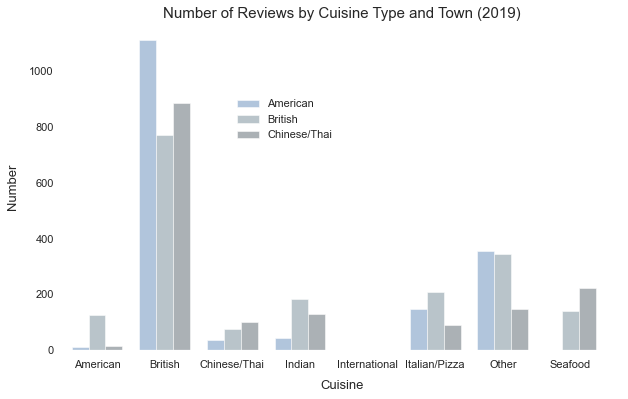

In [177]:
graphing_function3(cuisines,"Number of Reviews by Cuisine Type and Town (2019)","Number","Cuisine",(10,6))

In [178]:
# Contingency table ratings by Food Outlet Type
contingency2 = pd.crosstab(food.Rating,food["Cuisine"])
contingency2

Cuisine,American,British,Chinese/Thai,Indian,International,Italian/Pizza,Other,Seafood
Rating,,,,,,,,
1,21,208,22,39,2,22,12,43
2,12,195,15,22,0,16,16,19
3,20,245,20,45,0,27,45,37
4,19,572,45,63,0,79,115,61
5,80,1549,114,192,0,305,664,202


In [179]:
contingency2_percent = contingency2.T.apply(lambda x: x*100/sum(x),axis = 1)
contingency2_percent

Rating,1,2,3,4,5
Cuisine,,,,,
American,13.815789,7.894737,13.157895,12.500000,52.631579
British,7.511737,7.042254,8.847960,20.657277,55.940773
Chinese/Thai,10.185185,6.944444,9.259259,20.833333,52.777778
Indian,10.803324,6.094183,12.465374,17.451524,53.185596
International,100.000000,0.000000,0.000000,0.000000,0.000000
Italian/Pizza,4.899777,3.563474,6.013363,17.594655,67.928731
Other,1.408451,1.877934,5.281690,13.497653,77.934272
Seafood,11.878453,5.248619,10.220994,16.850829,55.801105


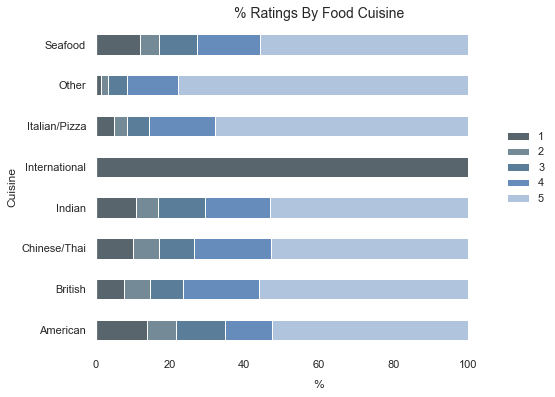

In [180]:
stacked(contingency2_percent, "% Ratings By Food Cuisine")

In [181]:
statistical("Ratings By Cuisine", food["Cuisine"], food["Rating"])

Ratings By Cuisine


,Chi-square test,results
0,Pearson Chi-square ( 28.0) =,249.4100
1,p-value =,0.0000
2,Cramer's V =,0.1099


British food is the dominant type unsurprisingly. There does appear to be a weak statistical relationship between the rating given and the type of cuisine being reviewed.

In [182]:
# Counts of food cuisine types
food.Cuisine.value_counts()

British          2769
Other             852
Italian/Pizza     449
Seafood           362
Indian            361
Chinese/Thai      216
American          152
International       2
Name: Cuisine, dtype: int64

# Section 10: Analysis of Food Outlet Establishment Types

In [183]:
# Counts of food outlet types
food["Outlet"].value_counts()

 Restaurant            2021
 Pub/Bar               1764
 Café                   818
 Steakhouse/Diner       256
 Fast Food/Takeaway     245
 Gastropub               59
Name: Outlet, dtype: int64

In [184]:
food.columns = ["Name","Category","Town","Contributions","Title","Review","Rating","Date","LocCode","Cuisine","Type"]

In [185]:
# Combine food categories into new ones for ease
food["Type"] = food["Type"].replace(["Gastropub","Pub/Bar"],"Pub")
food["Type"] = food["Type"].replace(["Cafe","Fast Food/Takeaway"],"FastFood/Cafe")

In [186]:
# Group food outlets by town
food_outlets = food.groupby("Town")["Type"].value_counts()
outlets = food_outlets.unstack().T
outlets.fillna(0)

Town,Arundel,Bognor,Littlehampton
Type,,,
Café,359.0,158.0,301.0
Fast Food/Takeaway,0.0,179.0,66.0
Gastropub,32.0,27.0,0.0
Pub/Bar,601.0,550.0,613.0
Restaurant,525.0,879.0,617.0
Steakhouse/Diner,194.0,60.0,2.0


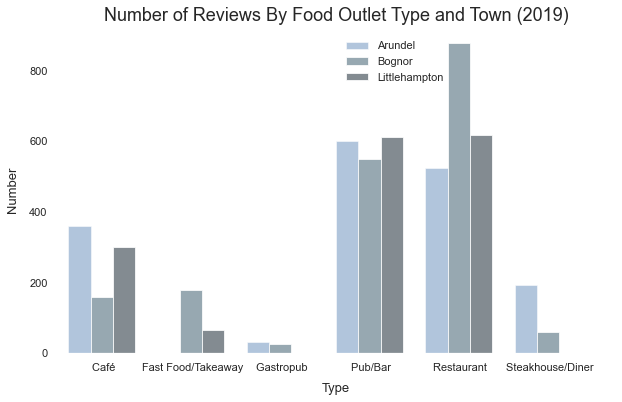

In [187]:
graphing_function2(outlets, "Number of Reviews By Food Outlet Type and Town (2019)", "Number","Type",outlets.columns,(10,6))

In [188]:
# Contingency table ratings by Food Outlet Type
contingency3 = pd.crosstab(food.Rating,food["Type"])
contingency3

Type,Café,Fast Food/Takeaway,Gastropub,Pub/Bar,Restaurant,Steakhouse/Diner
Rating,,,,,,
1,45,69,2,145,87,21
2,30,15,7,141,75,27
3,72,18,7,157,161,24
4,165,27,22,365,335,40
5,506,116,21,956,1363,144


In [189]:
contingency3_percent = contingency3.T.apply(lambda x: x*100/sum(x),axis = 1)
contingency3_percent

Rating,1,2,3,4,5
Type,,,,,
Café,5.501222,3.667482,8.801956,20.171149,61.858191
Fast Food/Takeaway,28.163265,6.122449,7.346939,11.020408,47.346939
Gastropub,3.389831,11.864407,11.864407,37.288136,35.593220
Pub/Bar,8.219955,7.993197,8.900227,20.691610,54.195011
Restaurant,4.304800,3.711034,7.966353,16.575952,67.441860
Steakhouse/Diner,8.203125,10.546875,9.375000,15.625000,56.250000


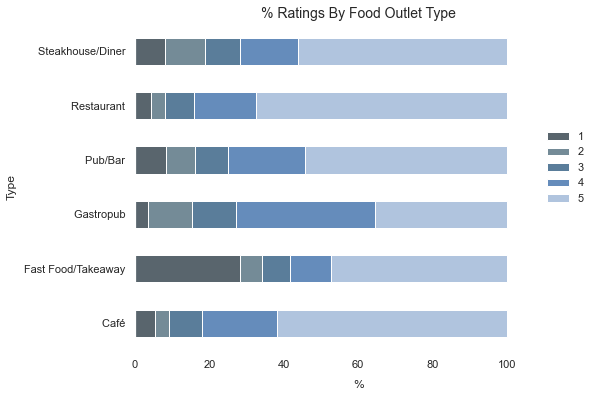

In [190]:
stacked(contingency3_percent, "% Ratings By Food Outlet Type")

Restaurants and pubs are the most popular type of food outlet. Arundel has no fast food and Gastropubs and Diners are only found in Bognor and Arundel.

In [191]:
statistical("Ratings By Food Outlet",food["Type"],food["Rating"])

Ratings By Food Outlet


,Chi-square test,results
0,Pearson Chi-square ( 20.0) =,306.5194
1,p-value =,0.0000
2,Cramer's V =,0.1218


Again a weak relationship between rating given and the type of food outlet. Restaurants are most highly rated and Gastropubs proportionally the lowest number of high ratings.

# Section 11: Analysis of Attraction Types

In [192]:
# Filter by attractions
attracts = combined[combined["Category"] == "Attractions"]

In [193]:
# Combine attractions into smaller number of categories for ease
attracts["Type"] = attracts["Type"].replace(["Bar&Club","Cinema","Comedy Club","Theatre"],"Nightlife")
attracts["Type"] = attracts["Type"].replace(["Speciality Shop","Market"],"Shopping")
attracts["Type"] = attracts["Type"].replace(["Church","Gallery","Historic","Landmarks","Museum"],"Historical/Culture")
attracts["Type"] = attracts["Type"].replace(["Animals","Nature Area","Parks & Gardens","Wildlife"],"Nature/Gardens")
attracts["Type"] = attracts["Type"].replace(["Beach","Marina","Pools","Racetracks","Golf","Golf Course","Shooting Range"],"Beach/Outdoor")
attracts["Type"] = attracts["Type"].replace(["Activity","Railways","Amusements","Fun & Games","Mini Golf"],"Amusements/Fun")
attracts["Type"] = attracts["Type"].replace(["Brewery","Wine Tours","Classes & Workshops"],"Classes/Workshops")
attracts["Type"] = attracts["Type"].replace(["Spa","Spa and Wellness","Leisure Centre"],"Spas/Leisure Centres")
          

In [194]:
attracts.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode
131,Arundel Castle,Attractions,Arundel,Historical/Culture,1244,Big surprise,From the outside the castle is very impressive...,5,2.0,3.0
1209,Digby Fine English,Attractions,Arundel,Classes/Workshops,1196,Very good wines,"Nice , helpful young man behind the counter.\n...",5,2.0,3.0


In [195]:
# Group by towns
attractions = attracts.groupby("Town")["Type"].value_counts()
attractions = attractions.unstack().T
attractions = attractions.fillna(0)

In [196]:
attractions

Town,Arundel,Bognor,Littlehampton
Type,,,
Amusements/Fun,4.0,42.0,52.0
Beach/Outdoor,6.0,17.0,61.0
Classes/Workshops,9.0,5.0,0.0
Historical/Culture,353.0,26.0,8.0
Nature/Gardens,151.0,64.0,11.0
Nightlife,2.0,82.0,11.0
Outdoor Activity,1.0,0.0,0.0
Shopping,16.0,17.0,12.0
Spas/Leisure Centres,0.0,2.0,29.0


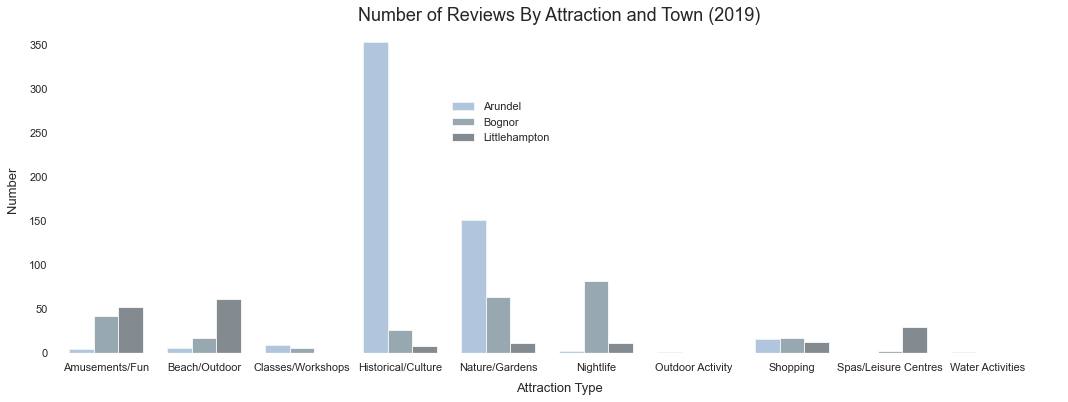

In [197]:
graphing_function2(attractions, "Number of Reviews By Attraction and Town (2019)", "Number", "Attraction Type",leg, (18,6))

In [198]:
# Contingency table ratings by Food Outlet Type
contingency4 = pd.crosstab(attracts.Rating,attracts["Type"])
contingency4

Type,Amusements/Fun,Beach/Outdoor,Classes/Workshops,Historical/Culture,Nature/Gardens,Nightlife,Outdoor Activity,Shopping,Spas/Leisure Centres,Water Activities
Rating,,,,,,,,,,
1,2,5,0,3,3,2,0,1,3,0
2,5,0,0,4,4,0,0,2,3,0
3,7,8,0,12,21,4,0,5,1,0
4,34,25,0,89,61,17,0,2,4,1
5,50,46,14,279,137,72,1,35,20,0


In [199]:
contingency4_percent = contingency4.T.apply(lambda x: x*100/sum(x),axis = 1)
contingency4_percent

Rating,1,2,3,4,5
Type,,,,,
Amusements/Fun,2.040816,5.102041,7.142857,34.693878,51.020408
Beach/Outdoor,5.952381,0.000000,9.523810,29.761905,54.761905
Classes/Workshops,0.000000,0.000000,0.000000,0.000000,100.000000
Historical/Culture,0.775194,1.033592,3.100775,22.997416,72.093023
Nature/Gardens,1.327434,1.769912,9.292035,26.991150,60.619469
Nightlife,2.105263,0.000000,4.210526,17.894737,75.789474
Outdoor Activity,0.000000,0.000000,0.000000,0.000000,100.000000
Shopping,2.222222,4.444444,11.111111,4.444444,77.777778
Spas/Leisure Centres,9.677419,9.677419,3.225806,12.903226,64.516129


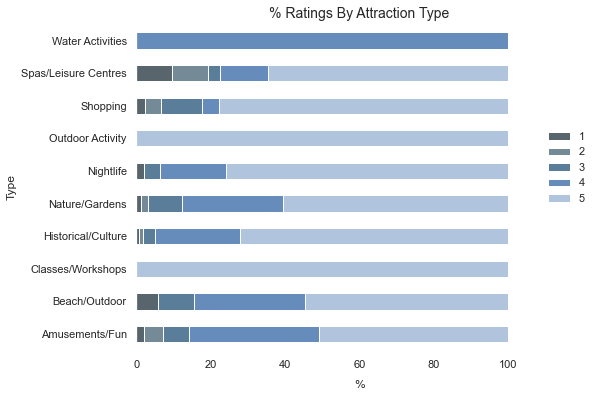

In [200]:
stacked(contingency4_percent, "% Ratings By Attraction Type")

In [201]:
statistical("Ratings and Attraction Types", attracts["Type"], attracts["Rating"])

Ratings and Attraction Types


,Chi-square test,results
0,Pearson Chi-square ( 36.0) =,95.1799
1,p-value =,0.0000
2,Cramer's V =,0.1557


Moderate relationship between attraction type and rating

# Section 12: Feature Engineering

In [202]:
# Create new dataframe of just hotels
hotels = combined[combined["Category"] == "Accommodation"]

In [203]:
# Replace types of accommodation with general category
hotels.Type = hotels.Type.replace(["Campsite","Speciality"],"AccomOther")

In [204]:
hotels.head(1)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode
731,Norfolk Arms,Accommodation,Arundel,Hotel,1278,Great value in the heart of arundel,Booked a room to stay the night in Arundel. Th...,4,4.0,2.0


In [205]:
hotels.shape

(1802, 10)

In [206]:
# Count of each type of accommodation
hotels.Type.value_counts()

Hotel         1350
B&B/Inn        263
AccomOther     189
Name: Type, dtype: int64

In [207]:
# Merge back to one dataframe
expl_one_df = pd.concat([hotels,food,attracts], ignore_index=True)

In [208]:
# Shape of new dataframe
expl_one_df.shape

(7947, 11)

In [209]:
# Check for null values
expl_one_df.isnull().sum()

Name                0
Category            0
Town                0
Type                0
Contributions       0
Title               0
Review              0
Rating              0
Date                0
LocCode             0
Cuisine          2784
dtype: int64

In [210]:
# Fill nulls with zero and drop text and title columns
expl_one_df = expl_one_df.fillna(0)
#expl_one_df.drop(columns = ["Title","Review"],axis = 1, inplace = True)

In [211]:
expl_one_df.head(1)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode,Cuisine
0,Norfolk Arms,Accommodation,Arundel,Hotel,1278,Great value in the heart of arundel,Booked a room to stay the night in Arundel. Th...,4,4.0,2.0,0


In [215]:
expl_one_df.to_csv("models1.csv")